In [11]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

# 시각화 옵션
plt.rcParams["figure.dpi"] = 120

In [12]:
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = (row - 900) * 0.1  # 900 오프셋 제거
    lon = (col - 1800) * 0.1  # 1800 오프셋 제거
    return lon, lat

# 정적 데이터

## population_density (인구밀도)
- Gridded Population of the World(GPW) v4 데이터(2020년 기준)를 사용하여 격자당 인구 수(명/km²)를 고정된 값으로 제공합니다.
- 인구 밀도가 높을수록 인간에 의한 의도적·비의도적 점화 가능성이 커지므로, 화재 점화 위험을 평가하는 데 중요한 변수로 작용합니다.

In [13]:
import pandas as pd
pop_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")
print(pop_df.info())
display(pop_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149290 entries, 0 to 1149289
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   grid_id  1149290 non-null  int64  
 1   value    1149290 non-null  float64
 2   date     1149290 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 26.3+ MB
None


,grid_id,value,date
0,4643451,475.01550,2000-01-01
1,4643451,472.50436,2000-01-01
2,4643452,372.50860,2000-01-01
3,4643452,279.89905,2000-01-01
4,4643452,266.38574,2000-01-01
...,...,...,...
1149285,4431118,82.77728,2020-01-01
1149286,4431119,82.77728,2020-01-01
1149287,4431119,82.77729,2020-01-01
1149288,4431119,82.77729,2020-01-01


공통 grid 수: 1,006
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 1,001
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 1,001
→ head: [4431089 4431090 4431091 4431092 4431093 4431094 4431095 4431096 4431097
 4431098 4431099 4431100 4431101 4431103 4431104 4431105 4431106 4431107
 4431108 4431109] ...


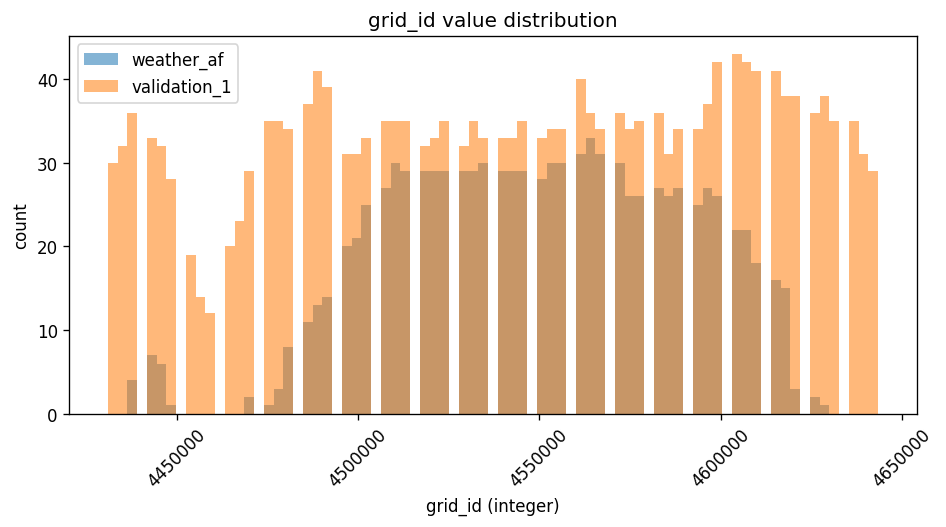

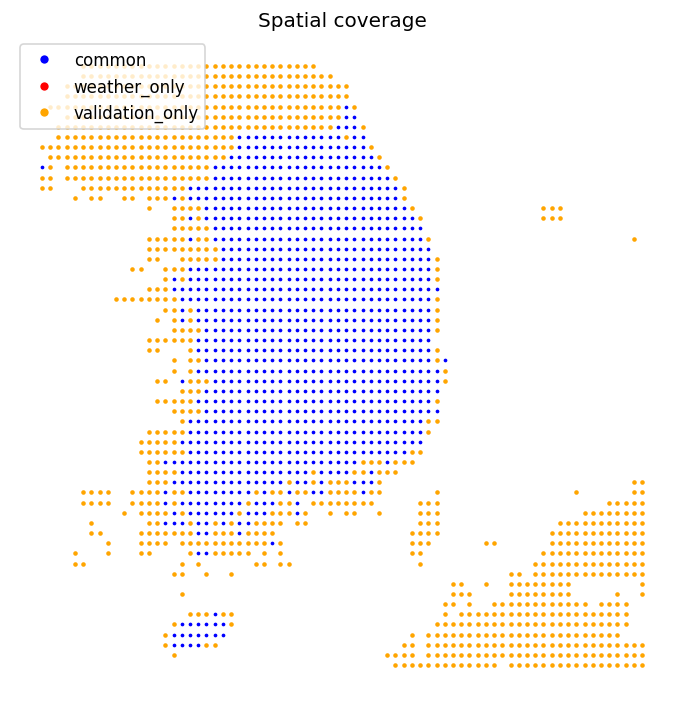

weather_af: no missing cells → heat-map skipped.
validation_1: no missing cells → heat-map skipped.
weather_af: no missing years → bar-plot skipped.
validation_1: no missing years → bar-plot skipped.


In [14]:
weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = (row - 900) * 0.1  # 900 오프셋 제거
    lon = (col - 1800) * 0.1  # 1800 오프셋 제거
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")

In [15]:
def temporal_profile(df: pd.DataFrame, label: str) -> None:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])

    uniq_dates = df["date"].drop_duplicates().sort_values()
    start, end = uniq_dates.min(), uniq_dates.max()

    deltas = uniq_dates.diff().dropna()
    deltas = deltas[deltas != pd.Timedelta(0)]     # 0초 차이 제거

    if deltas.empty:
        print(f"[{label}] 고유 날짜 {len(uniq_dates)}개 → 해상도 판별 불가")
        return

    print(f"[{label}] {start.date()} → {end.date()} | 고유 날짜 {len(uniq_dates):,}개")
    print("  · 최빈 간격:", deltas.mode()[0])
    print("  · 최소 간격:", deltas.min())
temporal_profile(weather_af, "weather_af")
temporal_profile(val1, "Validation-1")

[weather_af] 2005-01-05 → 2024-12-31 | 고유 날짜 3,656개
  · 최빈 간격: 1 days 00:00:00
  · 최소 간격: 1 days 00:00:00
[Validation-1] 2000-01-01 → 2020-01-01 | 고유 날짜 5개
  · 최빈 간격: 1826 days 00:00:00
  · 최소 간격: 1826 days 00:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# ─────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────
weather_af = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
val1 = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")

# ─────────────────────────────────────────────
# 2. grid_id → 경·위도 변환 함수
# ─────────────────────────────────────────────
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    row, col = divmod(int(grid_id), nlon)
    lat = -90 + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

# ─────────────────────────────────────────────
# 3. weather_af 기준 좌측 조인
# ─────────────────────────────────────────────
merged = weather_af.merge(
    val1[["grid_id"]], on="grid_id", how="left", indicator=True
)

# 매칭 성공 / 실패 집합
matched_ids = merged.loc[merged["_merge"] == "both", "grid_id"].unique()
missing_ids = merged.loc[merged["_merge"] == "left_only", "grid_id"].unique()

print(f"Total weather_af grid_id : {len(weather_af['grid_id'].unique()):,}")
print(f"Matched   grid_id        : {len(matched_ids):,}")
print(f"Missing   grid_id        : {len(missing_ids):,}")
print("\nMissing id head :", missing_ids[:30], "..." if len(missing_ids) > 30 else "")

# ─────────────────────────────────────────────
# 4. 좌표 변환 및 시각화
# ─────────────────────────────────────────────
# (A) GeoDataFrame 생성
gdf_match = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in matched_ids],
    crs="EPSG:4326"
)
gdf_missing = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in missing_ids],
    crs="EPSG:4326"
)

# (B) Plot
fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_match.empty:
    gdf_match.plot(ax=ax, markersize=8, color="royalblue",
                   label="matched")
if not gdf_missing.empty:
    gdf_missing.plot(ax=ax, markersize=8, color="crimson",
                     label="missing")

ax.set_title("Join result: weather_af ⇐ val1")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.legend(loc="lower left")
plt.tight_layout(); plt.show()


## road_density (도로밀도)
- Global Roads Inventory Dataset(2018년)을 통해 계산된 격자당 도로 총 길이(km/km²)를 고정된 값으로 제공합니다.
- 도로는 사람의 접근성을 높여 점화 가능성을 증가시키는 동시에, 소방 장비 진입 경로가 될 수도 있어 화재 예측 모형에서 중요한 입·출입 인프라 변수로 사용됩니다. 

In [16]:
import pandas as pd
road_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet")
print(road_df.info())
display(road_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   grid_id           2327 non-null   int64  
 1   road_dens_km_km2  2327 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 36.5 KB
None


,grid_id,road_dens_km_km2
0,4643450,0.000
1,4643451,0.122
2,4643452,0.510
3,4643453,0.392
4,4643454,0.897
...,...,...
2322,4431115,0.375
2323,4431116,0.499
2324,4431117,0.493
2325,4431118,0.437


공통 grid 수: 1,006
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 1,321
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 1,321
→ head: [4431061 4431062 4431063 4431089 4431090 4431091 4431092 4431093 4431094
 4431095 4431096 4431097 4431098 4431099 4431100 4431101 4431102 4431103
 4431104 4431105] ...


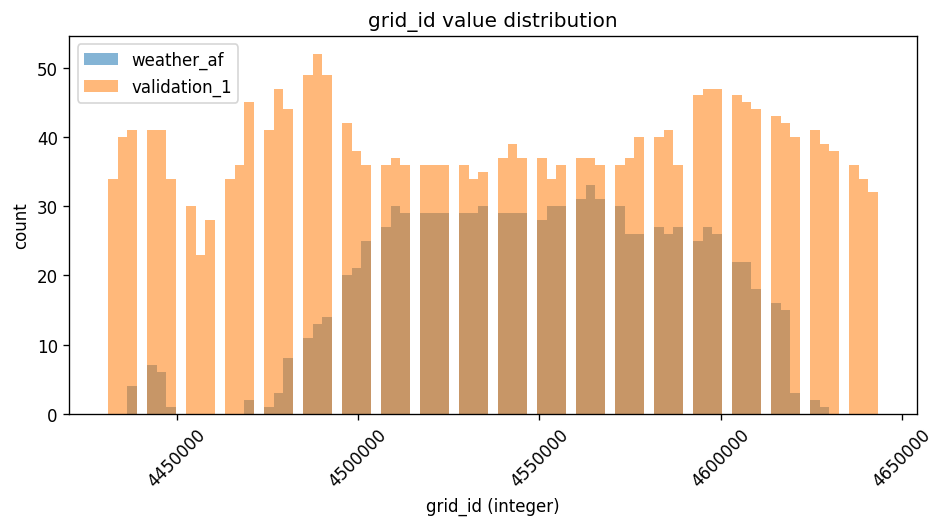

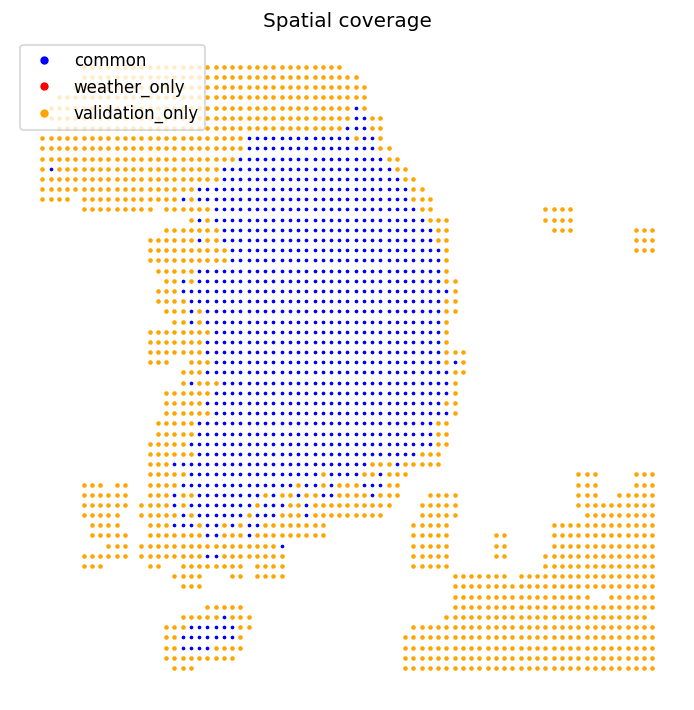

[Skip] validation_1: no date column detected → temporal plots skipped.
weather_af: no missing cells → heat-map skipped.
validation_1: no missing cells → heat-map skipped.
weather_af: no missing years → bar-plot skipped.


In [17]:
weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")



### 인구, 도로밀도 데이터 grid_id 이상 확인

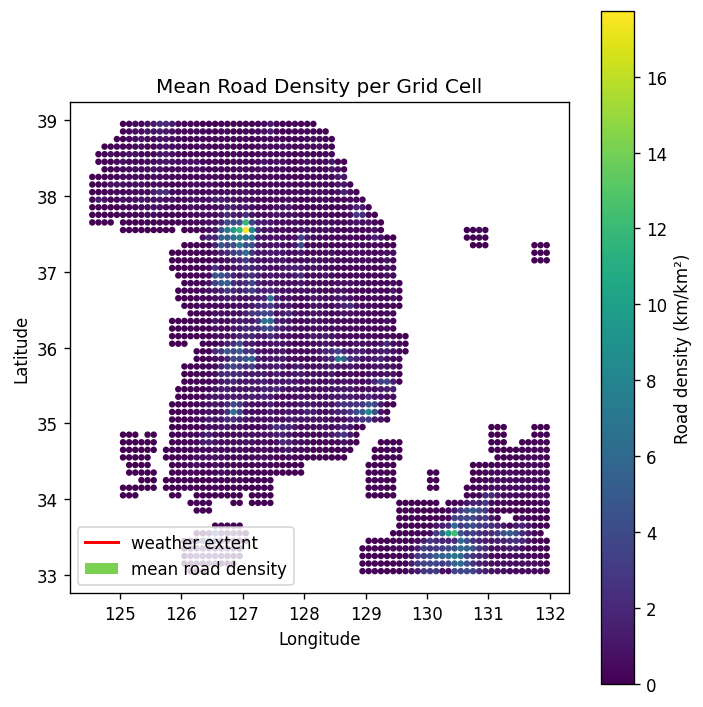

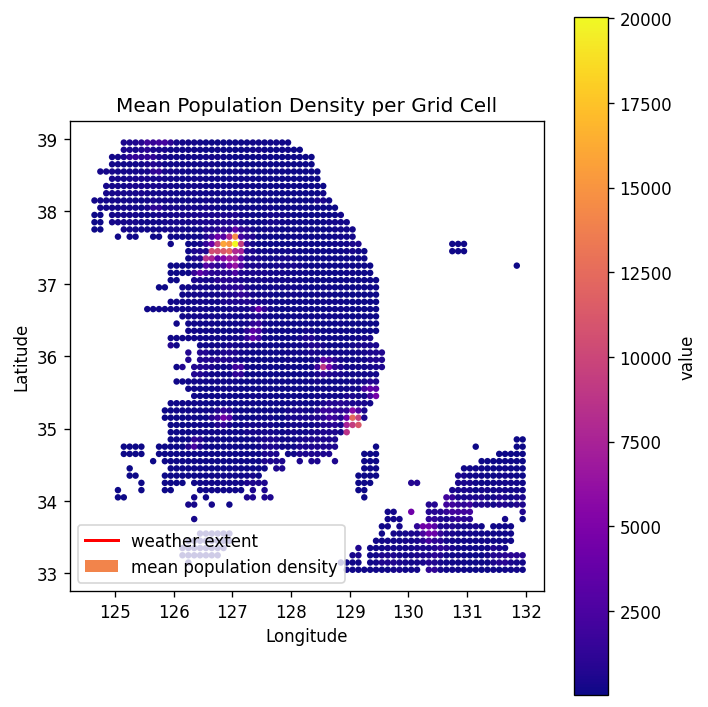

weather grid count : 1,006
road    grid count : 2,327  (outside=1321)
pop     grid count : 2,007  (outside=1001)


In [ ]:
# ======================================================================
# 0. IMPORT & 설정
# ======================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.lines  import Line2D
from matplotlib.patches import Patch

plt.rcParams["figure.dpi"] = 120   # 노트북/PNG 시각화 품질

# ======================================================================
# 1. 데이터 로드
# ======================================================================
weather = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
road = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet")
pop = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")

# ======================================================================
# 2. grid_id → (lon, lat) 변환 함수
# ======================================================================
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    """ERA5-Land 0.1° 격자용: 1-D grid_id → 중심 경·위도"""
    row, col = divmod(int(grid_id), nlon)
    lat = -90 + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

# ======================================================================
# 3. weather 격자 외곽선(빨간 실선) 생성 ─ 투영 CRS 사용
# ======================================================================
weather_ids = weather["grid_id"].unique()

# 3-A. Point GeoDataFrame (WGS84)
gdf_w = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in weather_ids],
    crs="EPSG:4326"
)

# 3-B. 한국 지역에 적합한 투영 좌표계(UTM 52N, EPSG:32652)로 변환
gdf_proj = gdf_w.to_crs(32652)

# 3-C. 5 km 버퍼로 셀 간 빈틈 제거 후 union_all → 외곽선 추출
weather_poly   = gdf_proj.buffer(5_000).union_all()
weather_border = gpd.GeoSeries(weather_poly.boundary, crs=32652).to_crs(4326)

# ======================================================================
# 4. road / pop 평균 + 좌표
# ======================================================================
road_mean = (road.groupby("grid_id", as_index=False)["road_dens_km_km2"]
                   .mean())
road_mean[["lon", "lat"]] = road_mean["grid_id"].apply(
    lambda g: pd.Series(grid_to_lonlat(g)))

pop_value_col = [c for c in pop.select_dtypes("number").columns
                 if c != "grid_id"][0]
pop_mean = (pop.groupby("grid_id", as_index=False)[pop_value_col].mean())
pop_mean[["lon", "lat"]] = pop_mean["grid_id"].apply(
    lambda g: pd.Series(grid_to_lonlat(g)))

# ======================================================================
# 5-A. ROAD density 지도 + 빨간 외곽선
# ======================================================================
fig, ax = plt.subplots(figsize=(6, 6))
weather_border.plot(ax=ax, color="none", edgecolor="red", lw=1.8)

sc = ax.scatter(road_mean["lon"], road_mean["lat"],
                c=road_mean["road_dens_km_km2"],
                cmap="viridis", s=15, linewidth=0)

plt.colorbar(sc, label="Road density (km/km²)")
ax.set_title("Mean Road Density per Grid Cell")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

ax.legend(handles=[
    Line2D([0], [0], color="red", lw=1.8, label="weather extent"),
    Patch(facecolor=plt.cm.viridis(0.8), edgecolor="none",
          label="mean road density")
], loc="lower left")
plt.tight_layout(); plt.show()

# ======================================================================
# 5-B. POPULATION density 지도 + 빨간 외곽선
# ======================================================================
fig, ax = plt.subplots(figsize=(6, 6))
weather_border.plot(ax=ax, color="none", edgecolor="red", lw=1.8)

sc2 = ax.scatter(pop_mean["lon"], pop_mean["lat"],
                 c=pop_mean[pop_value_col],
                 cmap="plasma", s=15, linewidth=0)

plt.colorbar(sc2, label=pop_value_col.replace('_', ' '))
ax.set_title("Mean Population Density per Grid Cell")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

ax.legend(handles=[
    Line2D([0], [0], color="red", lw=1.8, label="weather extent"),
    Patch(facecolor=plt.cm.plasma(0.7), edgecolor="none",
          label="mean population density")
], loc="lower left")
plt.tight_layout(); plt.show()

# ======================================================================
# 6. 수치 검증(road/pop 격자가 weather 범위 밖에 있는지)
# ======================================================================
road_only = np.setdiff1d(road_mean["grid_id"], weather_ids)
pop_only  = np.setdiff1d(pop_mean["grid_id"], weather_ids)

print(f"weather grid count : {len(weather_ids):,}")
print(f"road    grid count : {len(road_mean):,}  (outside={len(road_only)})")
print(f"pop     grid count : {len(pop_mean):,}  (outside={len(pop_only)})")

## Orography (지형)
- 해당 격자의 평균 해발 고도(m) 또는 지형 경사도를 ECLand를 통해 고정된 값으로 제공합니다.
- 고도가 높거나 경사가 가파르면 연료 건조도나 바람 흐름에 영향을 주므로, 화재 발생 가능성과 확산 속도 예측 시 중요합니다. 

## Urban_Frac (도시 분율)
- 해당 격자(cell) 내에서 도시 지역이 차지하는 비율(0~1)을 ECLand를 통해 고정된 값으로 제공합니다.
- 인위적 불꽃(쓰레기 소각, 난방 등) 발생 가능성과 소화 자원 접근성 등을 간접적으로 반영하여, 인간 인위 점화 확률에 영향을 미칩니다

In [28]:
import pandas as pd
urban_df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Urban Frac\urban_frac_korea_cleaned.csv")
print(urban_df.info())
display(urban_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   grid_id     4800 non-null   int64  
 1   lat         4800 non-null   float64
 2   lon         4800 non-null   float64
 3   urban_frac  4800 non-null   float64
 4   geometry    4800 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 187.6+ KB
None


,grid_id,lat,lon,urban_frac,geometry
0,1,33.05,124.05,0.0,POINT (124.05 33.05)
1,2,33.05,124.15,0.0,POINT (124.15 33.05)
2,3,33.05,124.25,0.0,POINT (124.25 33.05)
3,4,33.05,124.35,0.0,POINT (124.34999999999998 33.05)
4,5,33.05,124.45,0.0,POINT (124.44999999999996 33.05)
...,...,...,...,...,...
4795,4796,38.95,131.55,0.0,POINT (131.5499999999996 38.95000000000008)
4796,4797,38.95,131.65,0.0,POINT (131.64999999999958 38.95000000000008)
4797,4798,38.95,131.75,0.0,POINT (131.74999999999957 38.95000000000008)
4798,4799,38.95,131.85,0.0,POINT (131.84999999999957 38.95000000000008)


## Vegetation (식생 유형)
- ECMWF의 Land Surface Model(ECLand)을 통해 고정(Fixed)된 형태로 제공되는 식생 커버 유형(예: 숲, 초지, 농지 등)에 대한 범주형 정보입니다.
- 특정 식생 유형은 화재 확산 특성이 다르므로, 점화 및 연소 특성을 모델에 반영하기 위해 사용됩니다

In [90]:
import pandas as pd
vege_df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Vegetation\vegetation_type_korea.csv")
print(vege_df.info())
display(vege_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220800 entries, 0 to 6220799
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   date             object
 1   grid_id          int64 
 2   lead             int64 
 3   vegetation_type  int64 
dtypes: int64(3), object(1)
memory usage: 189.8+ MB
None


,date,grid_id,lead,vegetation_type
0,2022-01-01,4643440,0,210
1,2022-01-01,4643440,0,210
2,2022-01-01,4643440,0,210
3,2022-01-01,4643440,0,210
4,2022-01-01,4643440,0,210
...,...,...,...,...
6220795,2022-01-01,4431119,0,210
6220796,2022-01-01,4431119,0,210
6220797,2022-01-01,4431119,0,210
6220798,2022-01-01,4431119,0,210


공통 grid 수: 1,006
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 3,794
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 3,794
→ head: [4431040 4431041 4431042 4431043 4431044 4431045 4431046 4431047 4431048
 4431049 4431050 4431051 4431052 4431053 4431054 4431055 4431056 4431057
 4431058 4431059] ...


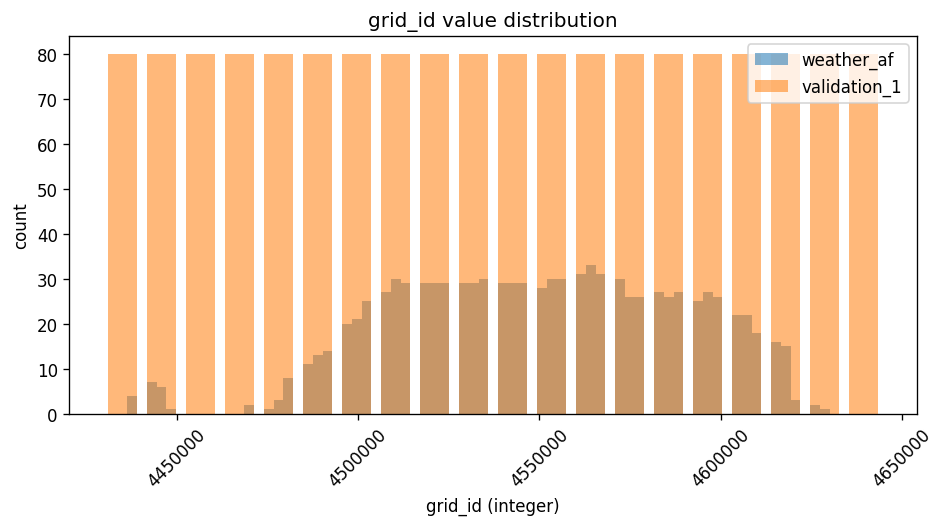

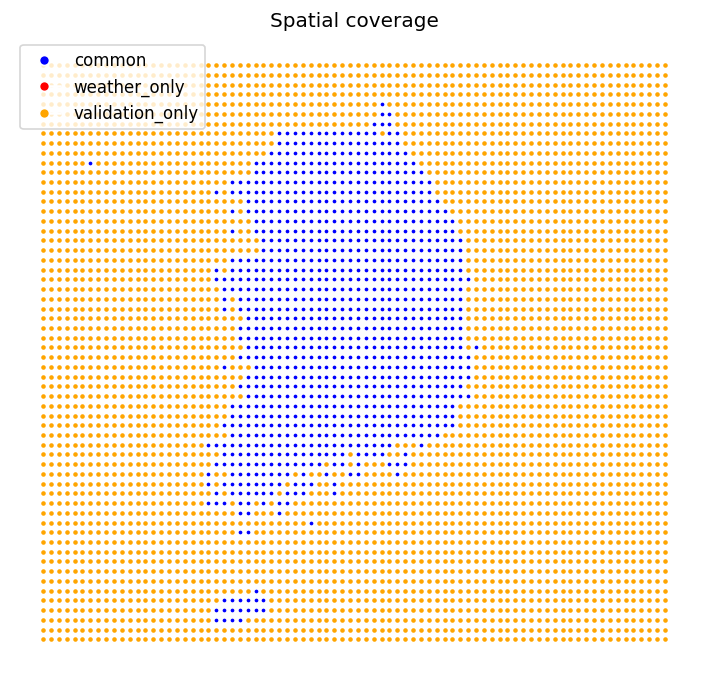

weather_af: no missing cells → heat-map skipped.
validation_1: no missing cells → heat-map skipped.
weather_af: no missing years → bar-plot skipped.
validation_1: no missing years → bar-plot skipped.


In [92]:
weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
val1 = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Vegetation\vegetation_type_korea.csv")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")


# 반 동적 데이터

## vod (식생 광학 두께)
- MOS 위성 자료를 기반으로 산출된 월별 단위의 식생 광학 두께(무차원)이며, 식생의 총 바이오매스 밀도를 간접적으로 나타냅니다.
- 높은 VOD 값은 상대적으로 높은 바이오매스(연료량)를 의미하므로, 연료 풍부도를 평가하는 데 활용됩니다. 

## lai_low_high_monthly (잎면적지수 - 저관목 LAI & 고관목 LAI)
- 저관목 LAI (Low Vegetation Leaf Area Index)
초본·관목 등 높이가 낮은 식생층의 잎 면적 지수(Leaf Area Index)로, 월별 단위로 제공됩니다. LAI는 단위 면적당 식생 잎의 총 면적을 나타내며, 값이 클수록 해당 격자의 연료(식생량)가 풍부함을 의미합니다. 저관목 LAI는 초지나 관목 지대의 연료량을 파악하여 화재 발생 시 초기 확산 가능성을 평가하는 데 활용됩니다.

- 고관목 LAI (High Vegetation Leaf Area Index)
교목·큰 관목 등 높이가 큰 식생층의 잎 면적 지수로, 월별 단위로 제공합니다. 숲 캐노피와 같은 고층 식생의 연료량을 나타내며, 값이 높으면 화재 시 강도(intensity)가 크고 지속 연소(smoldering)가 길어질 가능성이 큽니다. 고관목 LAI는 숲 지역 전체의 바이오매스 밀도를 간접적으로 파악하여 화재 확산 후 잔류 연소 기간을 예측하는 데 유용합니다.

In [ ]:
import pandas as pd
lai_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lai_low_high\lai_low_high_monthly.parquet")
print(lai_df.info())
display(lai_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502064 entries, 0 to 1502063
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   grid_id   1502064 non-null  int64         
 1   date      1502064 non-null  datetime64[ns]
 2   lai_low   1502064 non-null  float64       
 3   lai_high  1502064 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 45.8 MB
None


,grid_id,date,lai_low,lai_high
0,4427439,2000-01-01,0.0,0.0
1,4427439,2000-02-01,0.0,0.0
2,4427439,2000-03-01,0.0,0.0
3,4427439,2000-04-01,0.0,0.0
4,4427439,2000-05-01,0.0,0.0
...,...,...,...,...
1502059,4643519,2024-12-01,0.0,0.0
1502060,4643519,2025-01-01,0.0,0.0
1502061,4643519,2025-02-01,0.0,0.0
1502062,4643519,2025-03-01,0.0,0.0


array([0.   , 2.855, 2.867, ..., 1.411, 0.006, 1.696])

공통 grid 수: 1,006
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 3,935
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 3,935
→ head: [4427439 4427440 4427441 4427442 4427443 4427444 4427445 4427446 4427447
 4427448 4427449 4427450 4427451 4427452 4427453 4427454 4427455 4427456
 4427457 4427458] ...


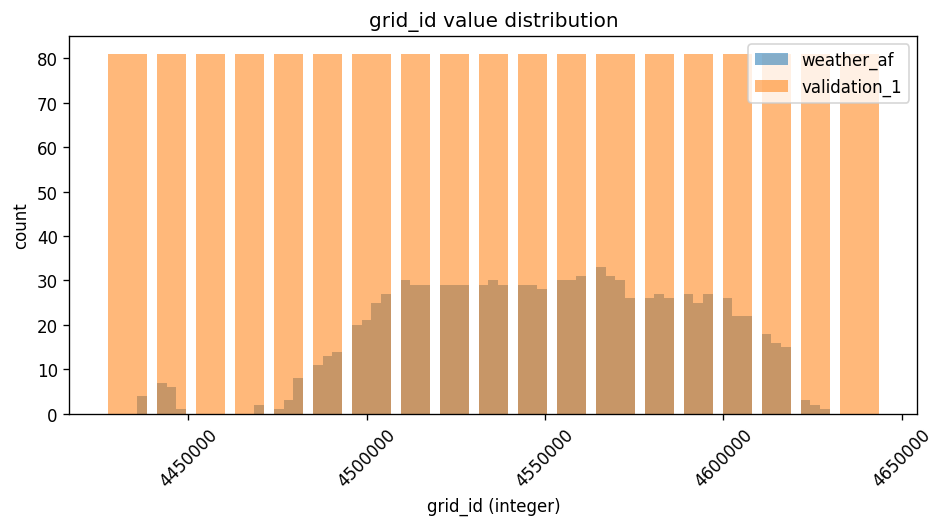

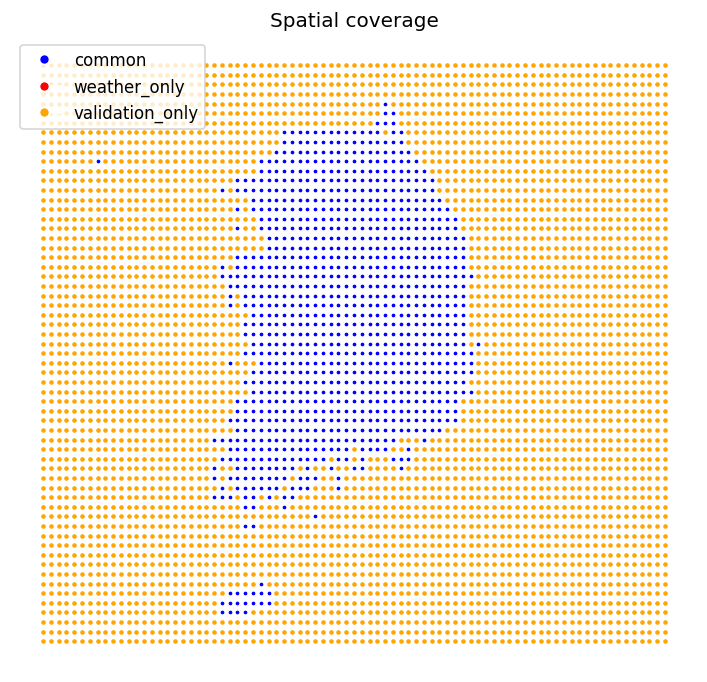

weather_af: no missing cells → heat-map skipped.
validation_1: no missing cells → heat-map skipped.
weather_af: no missing years → bar-plot skipped.
validation_1: no missing years → bar-plot skipped.


In [27]:
weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lai_low_high\lai_low_high_monthly.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")


## LFMC (생 연료 수분 함량)
- 살아 있는 연료(생엽·생목)의 수분 함량(%)을 일일 단위로 제공합니다.
- 수분 함량이 낮을수록 가연성이 높아져 화재 발생 및 확산 가능성이 커지므로, 실시간 연료 건조도를 평가하는 지표로 사용됩니다.

## DFMC (고엽 수분함량, 고목 수분함량)
- 말라 있는 잎(고엽)의 수분 함량(%)을 일일 단위로 제공합니다.
- 고엽은 일반적으로 저수분 상태이므로 높은 가연성을 띠며, 화재 점화와 초기 확산 단계에서 중요한 역할을 합니다. 
- 죽어 말라 있는 나무(줄기·가지 등) 부위의 생체량(kg/m²)을 일일 단위로 제공합니다.
- 축적된 사체 연료(dead woody fuel)는 화재 강도 및 잔존 연소(smoldering) 기간을 결정짓는 핵심 요인이 됩니다. 

In [6]:
import pandas as pd
dfmc_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\DFMC_combined\DFMC_combined_2011_2021.parquet")
print(dfmc_df.info())
display(dfmc_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12006507 entries, 0 to 12006506
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   time          datetime64[ms]
 1   grid_id       int64         
 2   DFMC_Foliage  float64       
 3   DFMC_Wood     float64       
dtypes: datetime64[ms](1), float64(2), int64(1)
memory usage: 366.4 MB
None


,time,grid_id,DFMC_Foliage,DFMC_Wood
0,2011-01-01 12:00:00,4643452,63.995300,42.152823
1,2011-01-01 12:00:00,4643453,69.443580,44.314877
2,2011-01-01 12:00:00,4643453,70.520334,43.929426
3,2011-01-01 12:00:00,4643454,68.940136,44.333165
4,2011-01-01 12:00:00,4643455,70.382741,45.534686
...,...,...,...,...
12006502,2021-12-31 11:30:00,4431116,70.573594,43.308077
12006503,2021-12-31 11:30:00,4431117,70.514704,43.043787
12006504,2021-12-31 11:30:00,4431117,69.199734,42.963426
12006505,2021-12-31 11:30:00,4431118,69.888206,43.003545


## FUEL (생엽 연료량, 생목 연료량, 고엽 연료량)

- 생엽 연료량 (Live Leaf Fuel Load)
살아 있는 식생의 잎 부분에 해당하는 생체량(kg/m²)으로, 일일 단위로 제공됩니다. 화재 시 잎이 가장 먼저 마르고 쉽게 점화되기 때문에, 표면 연료(surface fuel) 중 초기 점화와 빠른 확산에 가장 큰 영향을 미치는 지표로 사용됩니다.

- 생목 연료량 (Live Wood Fuel Load)
살아 있는 나무(줄기·가지 등)의 생체량(kg/m²)으로, 일일 단위로 제공합니다. 잎에 비해 연소 속도는 느리지만, 화재 발생 후 지속적인 연소와 높은 열 방출에 기여하므로 화재 강도와 규모를 예측하는 데 중요합니다.

- 고엽 연료량 (Dead Foliage Fuel Load)
말라 죽은 잎(고엽)의 생체량(kg/m²)으로, 일일 단위로 제공합니다. 이미 건조된 상태이므로 점화가 매우 쉬워 초기 화재 확산 단계에서 결정적인 역할을 합니다. 살아 있는 연료와 달리 상대적으로 저수분 상태를 유지하므로, 초기 화재 위험을 평가할 때 필수적인 변수입니다.

In [5]:
import pandas as pd
fuel_df = pd.read_parquet(r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\FUEL_combined\FUEL_combined_2011_2021.parquet')
print(fuel_df.info())
display(fuel_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36095423 entries, 0 to 36095422
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   time          datetime64[ms]
 1   grid_id       int64         
 2   Live_Leaf     float64       
 3   Live_Wood     float64       
 4   Dead_Foliage  float64       
 5   Dead_Wood     float64       
dtypes: datetime64[ms](1), float64(4), int64(1)
memory usage: 1.6 GB
None


,time,grid_id,Live_Leaf,Live_Wood,Dead_Foliage,Dead_Wood
0,2011-01-01 00:00:00,4643440,0.000000,0.000000,0.000000,2.935530e-08
1,2011-01-01 00:00:00,4643441,0.000000,0.000000,0.000000,2.935530e-08
2,2011-01-01 00:00:00,4643442,0.000000,0.000000,0.000000,2.935530e-08
3,2011-01-01 00:00:00,4643442,0.000000,0.000000,0.000000,2.935530e-08
4,2011-01-01 00:00:00,4643443,0.000000,0.000000,0.000000,2.935530e-08
...,...,...,...,...,...,...
36095418,2021-12-02 06:00:00,4431116,0.042049,3.599366,1.291799,1.464309e+00
36095419,2021-12-02 06:00:00,4431117,0.168800,4.782668,0.800355,9.678589e-01
36095420,2021-12-02 06:00:00,4431117,0.162026,6.370829,0.836711,1.016110e+00
36095421,2021-12-02 06:00:00,4431118,0.114782,5.452311,1.125022,1.366252e+00


# 동적 데이터

## 기상청 낙뢰